In [1]:
import os
import os.path as osp
join = osp.join
import numpy as np
from glob import glob
import torch
from segment_anything import sam_model_registry
from tqdm import tqdm
import argparse
import SimpleITK as sitk
import torch.nn.functional as F
from torch.utils.data import DataLoader
import SimpleITK as sitk
import torchio as tio
import numpy as np
from collections import OrderedDict, defaultdict
import json
import pickle
from itertools import product

from torchio.data.io import sitk_to_nib

from IPython.display import clear_output
import time

# Remake predictor example

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from utils.modelUtils import load_sam
from classes.SAMClass import SAMWrapper, SAMInferer

from utils.base_classes import Points
import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

In [3]:
import pickle
with open('/home/t722s/Desktop/test/input_point.pkl', 'rb') as f:
    input_point_sam = pickle.load(f)

In [4]:
# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'

sam_model = load_sam(checkpoint_path, device)
sam_wrapper = SAMWrapper(sam_model, device)
sam_inferer = SAMInferer(sam_wrapper, device)

In [5]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:,:,0]
image_3d = np.zeros((128, image.shape[0], image.shape[1]))
image_3d[0] = image

In [6]:
import importlib
import classes.SAMClass as c
importlib.reload(c)
sam_inferer = c.SAMInferer(sam_wrapper, device)

from utils.base_classes import Points
input_point = np.array([[500, 375]])
input_label = np.array([1])
input_point_3d = np.array([[0, 375, 500]])
prompt = Points({'coords': input_point_3d,'labels': input_label})

segmentation = sam_inferer.predict(image_3d, prompt)

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


In [7]:
input_point_sam

tensor([[[284.4445, 213.4375]]], device='cuda:0')

In [8]:
sam_inferer.preprocessed_points_dict

{0: (tensor([[284.4445, 213.4375]]), tensor([1]))}

In [9]:
s = segmentation[0]
anUt.compute_dice(s, image)

0.00013442967424849437

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


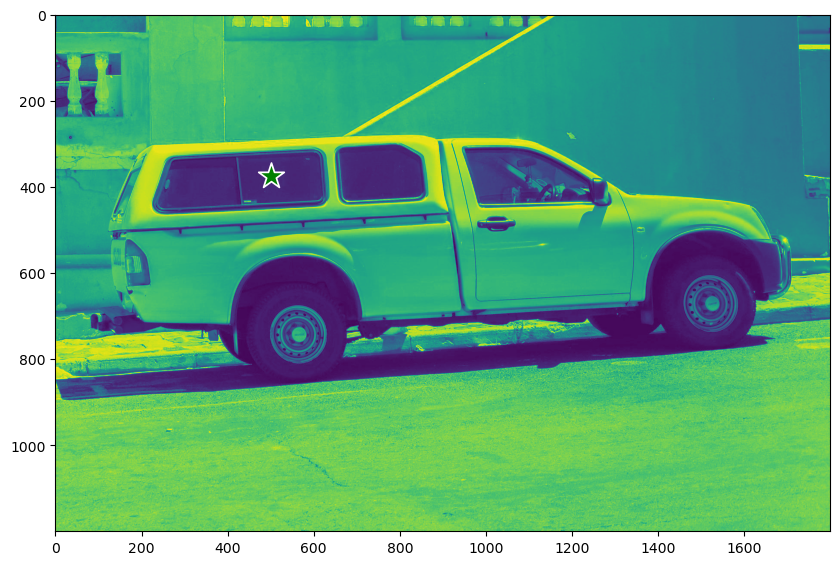

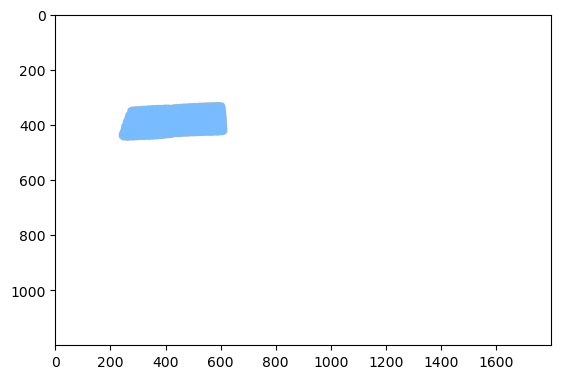

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  
show_mask(s, plt.gca())